In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# 1. Load the dataset
# Make sure the file path is correct for your local environment
file_path = r"sample_dataAnalys.xlsx"
df = pd.read_excel(file_path)



In [3]:
# 2. Preprocessing
# Ensure the date is in datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

In [4]:
#3. Define the "Snapshot Date" 
# We use one day after the most recent sale to calculate 'Recency'
snapshot_date = df['TransactionDate'].max() + pd.Timedelta(days=1)

In [5]:
print(df.columns.tolist())

['CustomerCode', 'CustomerName', 'DivisionName', 'ItemCode', 'ItemName', 'ItemQty', 'Salesman', 'TransactionDate', 'SUM_ItemTotal']


In [6]:
# 4. Aggregate Data for RFM
# R: Days since last purchase
# F: Number of unique days the customer made a purchase
# M: Sum of all purchases
rfm = df.groupby('CustomerCode').agg({
    'TransactionDate': lambda x: (snapshot_date - x.max()).days,
    'ItemName': 'nunique', # You can use 'count' for total items or 'nunique' for variety
    'SUM_ItemTotal': 'sum'
})

# Rename columns
rfm.rename(columns={
    'TransactionDate': 'Recency',
    'ItemName': 'Frequency',
    'SUM_ItemTotal': 'Monetary'
}, inplace=True)

In [7]:
# 5. Create Quintile Scores (1-5)
# For Recency: 1 is "long ago" (bad), 5 is "very recent" (good)
# For F & M: 1 is "low" (bad), 5 is "high" (good)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Create a combined segment label (e.g., "555")
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [8]:
# 6. Define Customer Segments based on Scores
def segment_customer(df):
    score = int(df['RFM_Segment'])
    if score >= 550:
        return 'Champions'
    elif score >= 440:
        return 'Loyal Customers'
    elif score >= 330:
        return 'Potential Loyalist'
    elif score >= 220:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment_Name'] = rfm.apply(segment_customer, axis=1)

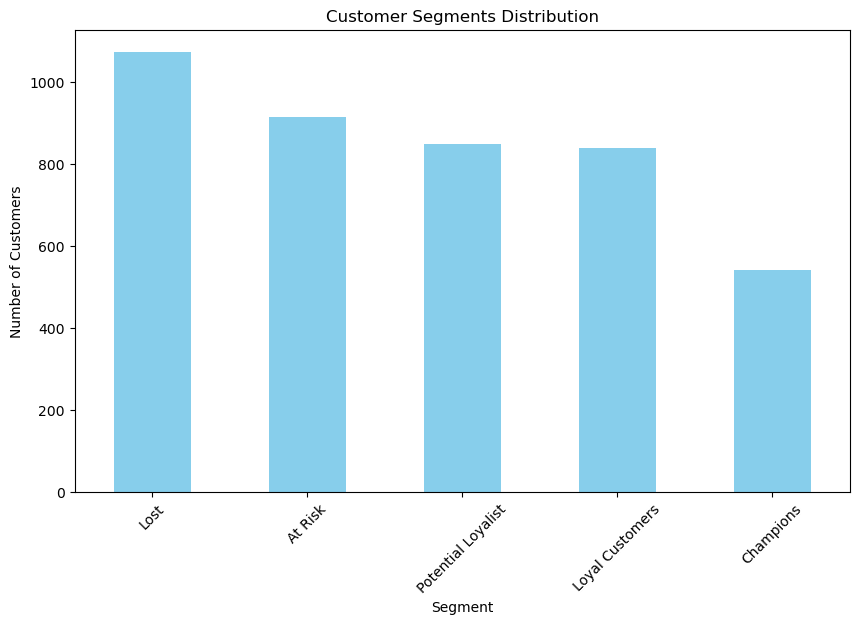

RFM Analysis Complete. Preview of the top customers:
              Recency  Frequency    Monetary R_Score F_Score M_Score  \
CustomerCode                                                           
C11175              6        528  4681732.98       4       5       5   
C18512              1        642  3982751.57       5       5       5   
C14052              2         99  1553784.45       5       5       5   
C11202              1        357  1409112.36       5       5       5   
C11115              2        117  1296770.55       5       5       5   

             RFM_Segment     Segment_Name  
CustomerCode                               
C11175               455  Loyal Customers  
C18512               555        Champions  
C14052               555        Champions  
C11202               555        Champions  
C11115               555        Champions  


In [30]:
# 7. Visualization
plt.figure(figsize=(10, 6))
rfm['Segment_Name'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

print("RFM Analysis Complete. Preview of the top customers:")
print(rfm.sort_values('Monetary', ascending=False).head())

In [9]:
# 1. Create a Mapping of Code to Name
# This ensures we don't lose the names during the groupby
name_mapping = df[['CustomerCode', 'CustomerName']].drop_duplicates('CustomerCode')

# 2. Merge the names into the RFM table
# We join on 'CustomerCode'
rfm_with_names = rfm.reset_index().merge(name_mapping, on='CustomerCode', how='left')

# 3. Reorder columns so Name is right next to the Code
cols = ['CustomerCode', 'CustomerName', 'Recency', 'Frequency', 'Monetary', 
        'R_Score', 'F_Score', 'M_Score', 'RFM_Segment', 'Segment_Name']
rfm_with_names = rfm_with_names[cols]

# 4. Export to Excel
output_file = "SAMPLE_Sales_Customer_Segmentation_Report.xlsx"

with pd.ExcelWriter(output_file) as writer:
    # Main Data Sheet
    rfm_with_names.sort_values('Monetary', ascending=False).to_excel(
        writer, sheet_name='Customer_Analysis', index=False
    )
    
    # Summary Sheet for Management
    segment_summary = rfm_with_names.groupby('Segment_Name').agg({
        'CustomerCode': 'count',
        'Monetary': ['mean', 'sum']
    }).round(2)
    segment_summary.to_excel(writer, sheet_name='Executive_Summary')

print(f"Done! The file '{output_file}' now includes both Customer Codes and Names.")

Done! The file 'SAMPLE_Sales_Customer_Segmentation_Report.xlsx' now includes both Customer Codes and Names.
